In [1]:
import xarray as xr
import numpy as np 
import os
import types
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import util_cesm
from src import config_cesm
from src.models import models_util

reference_grid = util_cesm.generate_sps_grid()

def load_globals(module):
    """
    Load all global variables declared in a module as a dictionary.
    
    Parameters:
        module (module): The loaded Python module.
    
    Returns:
        dict: A dictionary containing global variables from the module.
    """
    return {
        name: value
        for name, value in vars(module).items()
        if not name.startswith("__") and not isinstance(value, types.ModuleType) and not callable(value)
    }

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords


def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted


def load_model_predictions(config, nn_ens_avg=True, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    """
    If the config specifies that the predictions are anomalies, then the climatology is added back
    WITH clipping of unphysical values (e.g., if anomaly prediction is -0.5 but the climatology for that
    cell is 0.3, then the resulting value will be clipped to 0).
    """
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, config["EXPERIMENT_NAME"])
    output_path = os.path.join(output_dir, f"{config["MODEL"]}_{config["CHECKPOINT_TO_EVALUATE"]}_predictions.nc")
    predictions = xr.open_dataset(output_path).predictions 

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        predictions = add_climatology(predictions, climatology_broadcasted)

    if nn_ens_avg and ("nn_member_id" in predictions.dims): 
        predictions = predictions.mean("nn_member_id")

    return predictions 

def load_targets(config, split, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)
    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config["DATA_SPLIT_SETTINGS"]["name"])
    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        targets = add_climatology(targets, climatology_broadcasted)

    return targets

def get_broadcast_climatology(config, split):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)

    empty_predictions_da = models_util.generate_empty_predictions_ds(reference_grid, 
            time_coords, 
            ensemble_members,
            config["MAX_LEAD_MONTHS"], 80, 80).predictions 
    
    return broadcast_climatology_like(config["DATA_SPLIT_SETTINGS"], empty_predictions_da)

def roll_acc(acc):
    return xr.concat(
        [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
        dim="lead_time"
    )

def aggregate_acc(acc, dim):
    if dim == ("x", "y"):
        acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")
    else: 
        raise ValueError()
        
    # roll in lead time so that it gets lined up
    return roll_acc(acc)

def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - pred_anom  (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth_anom (xr.DataArray): True anomalies with dimensions including `dim`.
    - aggregate          (bool): if True, mean-aggregate down to dims (month, lead_time) 
    - dim                 (str): The dimension over which to calculate the ACC.
                                 Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        acc = aggregate_acc(acc, dim)

    return acc

class ModelDiagnostics():
    """
    This wrapper class is used to evaluate the model predictions for a given experiment configuration.
    """

    def __init__(self, config, nn_ens_avg, climatology_broadcasted: xr.DataArray = None):
        """
        Expected: 
            config (dict)       dictionary of the experiment configuration 
            nn_ens_avg (bool)   if the predictions include multiple neural net ensemble members, 
                                this averages the predictions if set to true. 

        Optional:
            climatology_broadcasted (xr.DataArray)  climatology broadcasted to the same shape \
                as the model predictions. If not provided, then it will be loaded according to \
                config. Note that this can take a long time, so if possible it is preferable \
                to supply the climatology_broadcasted array.
        """

        self.config = config
        self.nn_ens_avg = nn_ens_avg 

        # load climatology if not provided
        if climatology_broadcasted is None:
            self.climatology_broadcasted = get_broadcast_climatology(config, "test")
        else:
            self.climatology_broadcasted = climatology_broadcasted

        # load predictions and targets into xr.DataArray 
        self.predictions = self.load_model_predictions_wrapper()
        self.predictions_anomaly = remove_climatology(self.predictions, self.climatology_broadcasted)

        self.targets = self.load_targets_wrapper()
        self.targets_anomaly = remove_climatology(self.targets, self.climatology_broadcasted)

        # calculate linear difference
        self.diff = self.predictions - self.targets
        
    def load_model_predictions_wrapper(self):
        return load_model_predictions(self.config, self.nn_ens_avg, climatology_broadcasted=self.climatology_broadcasted) 

    def load_targets_wrapper(self):
        return load_targets(self.config, "test", climatology_broadcasted=self.climatology_broadcasted)

    def calculate_acc(self, aggregate, dim):
        return calculate_acc(self.predictions_anomaly, self.targets_anomaly, aggregate, dim)

P_VALUE_CUTOFF = 0.05

import matplotlib.patches as mpatches

def add_hatching(ax, significance_mask, x_edges, y_edges, hatch='///', edgecolor='k'):
    Ny, Nx = significance_mask.shape

    for i in range(Ny):
        for j in range(Nx):
            if significance_mask[i, j]:
                rect = mpatches.Rectangle(
                    (x_edges[j], y_edges[i]),
                    x_edges[j+1] - x_edges[j],
                    y_edges[i+1] - y_edges[i],
                    hatch=hatch,
                    fill=False,
                    edgecolor=edgecolor,
                    linewidth=0
                )
                ax.add_patch(rect)

def plot_markers(ax, exceeds_persistence, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if not exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 


def fisher_z(r):
    r = xr.where(np.abs(r) >= 0.999999, np.sign(r) * 0.999999, r) 
    return 0.5 * np.log((1.0 + r) / (1.0 - r))

def bootstrap_acc_significance(
    acc_a: xr.DataArray,
    acc_b: xr.DataArray,
    n_boot: int = 5000,
    alpha: float = 0.05,
    block: str = "year",
    random_state: int | None = None,
):
    """
    Compare two sets of spatial ACCs that verify against the same truth field.
    Implements a paired Fisher‑z transform and a block bootstrap on years.

    Parameters
    ----------
    acc_a, acc_b : xr.DataArray
        Dimensions can include
            - nn_member_id (optional)
            - member_id       (required if present in either input)
            - start_prediction_month (datetime64, required)
            - lead_time       (required)
        The two arrays are automatically aligned/broadcast.
    n_boot : int
        Number of bootstrap resamples.
    alpha : float
        Significance level for the two‑sided CI (default 0.05 → 95 % CI).
    block : {"year", "season", None}
        Resampling block.  If None, pairs are assumed independent in time.
    random_state : int | None
        Seed for reproducibility.

    Returns
    -------
    xr.Dataset with variables
        delta_z   : mean Fisher‑z difference
        p_value   : two‑sided bootstrap p‑value
        ci_low / ci_high : lower / upper (1‑alpha) CI bounds
    All with dims ('month', 'lead_time').
    """
    rng = np.random.default_rng(random_state)
    acc_a, acc_b = xr.align(acc_a, acc_b, join="inner", copy=False)

    # If persistence lacks nn_member_id, add a degenerate dim so broadcasting works
    if "nn_member_id" in acc_a.dims and "nn_member_id" not in acc_b.dims:
        acc_b = acc_b.expand_dims(nn_member_id=acc_a.nn_member_id)

    z_a = fisher_z(acc_a)
    z_b = fisher_z(acc_b)

    d = z_a - z_b
    
    def _bootstrap_mean(diff_da):
        """Return mean diff, p-value, CI for a (year, sample) DataArray."""
        years = np.unique(diff_da["year"].values)
        idx_by_year = {yr: np.where(diff_da["year"].values == yr)[0] for yr in years}

        boot_means = np.empty(n_boot)
        for b in range(n_boot):
            samp_years = rng.choice(years, size=len(years), replace=True)
            mask = np.concatenate([idx_by_year[yr] for yr in samp_years])
            boot_means[b] = diff_da.values[mask].mean()

        boot_means = np.sort(boot_means)
        ci_low = np.quantile(boot_means, alpha / 2)
        ci_hi  = np.quantile(boot_means, 1 - alpha / 2)

        # two-sided p-value: proportion of boot_means whose sign is opposite to mean
        p_val = 2 * min(
            (boot_means <= 0).mean(),
            (boot_means >= 0).mean(),
        )
        return diff_da.mean().item(), p_val, ci_low, ci_hi

    d = d.assign_coords(
        year=("start_prediction_month", d["start_prediction_month"].dt.year.data),
        month=("start_prediction_month", d["start_prediction_month"].dt.month.data),
    )


    months = np.arange(1, 13, dtype=int)
    leads  = d["lead_time"].values

    out = {
        "delta_z":  np.full((12, 6), np.nan),
        "p_value":  np.full((12, 6), np.nan),
        "ci_low":   np.full((12, 6), np.nan),
        "ci_high":  np.full((12, 6), np.nan)
    }

    for mi, m in enumerate(months):
        dm = d.where(d["month"] == m, drop=True)
        if dm.size == 0:
            continue
        for li, lead in enumerate(leads):
            subset = dm.sel(lead_time=lead)
            subset_flat = subset.stack(sample=subset.dims).dropna("sample")
            delta, p, lo, hi = _bootstrap_mean(subset_flat)
            out["delta_z"][mi, li] = delta
            out["p_value"][mi, li] = p
            out["ci_low"][mi, li]  = lo
            out["ci_high"][mi, li] = hi

    ds_out = xr.Dataset(
        {k: xr.DataArray(v,
                         coords={"month": months, "lead_time": leads},
                         dims=("month", "lead_time"))
         for k, v in out.items()}
    )
    return ds_out


In [3]:
from src.experiment_configs.exp1_inputs import input2 
from src.experiment_configs.exp1_inputs import input3a
from src.experiment_configs.exp1_inputs import input3b
from src.experiment_configs.exp1_inputs import input3c
from src.experiment_configs.exp1_inputs import input4 

cdicts = {
    "input2": input2, 
    "input3a": input3a, 
    "input3b": input3b, 
    "input3c": input3c, 
    "input4": input4
}

input2_cdict = load_globals(input2)
climatology_broadcast = get_broadcast_climatology(input2_cdict, "test")

In [3]:
import gc

targets = load_targets(input2_cdict, "test", add_climatology_to_anomaly=False)

acc = {}
acc_agg = {}

num_nn_ens_members = 5 
for key, config in cdicts.items():
    print(f"computing ACC for {key}")
    cdict = load_globals(config) 
    pred = load_model_predictions(cdict, nn_ens_avg=False, climatology_broadcasted=None, 
                                    add_climatology_to_anomaly=False)

    acc_temp_list = []
    for i in range(num_nn_ens_members): 
        acc_temp = calculate_acc(pred.isel(nn_member_id=i), 
                            targets, dim=("x","y"), aggregate=False)
        acc_temp_list.append(acc_temp)
    acc[key] = xr.concat(acc_temp_list, dim="nn_member_id")
    acc_agg[key] = aggregate_acc(acc[key], dim=("x","y"))



computing ACC for input2
computing ACC for input3a
computing ACC for input3b
computing ACC for input3c
computing ACC for input4


In [ ]:
save_dir = os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, "exp1_inputs")
os.makedirs(save_dir, exist_ok=True)
for key, _ in cdicts.items():
    acc[key].to_netcdf(os.path.join(save_dir, f"ACC_{key}.nc"))
    acc_agg[key].to_netcdf(os.path.join(save_dir, f"ACC_agg_{key}.nc"))


In [4]:
# load saved acc 
acc = {}
acc_agg = {}

save_dir = os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, "exp1_inputs")
for key in cdicts.keys():
    acc[key] = xr.open_dataset(os.path.join(save_dir, f"ACC_{key}.nc"))["__xarray_dataarray_variable__"]
    acc_agg[key] = xr.open_dataset(os.path.join(save_dir, f"ACC_agg_{key}.nc"))["__xarray_dataarray_variable__"]

#### Compute baseline forecasts

In [33]:
from src.models import models 

print(f"Loading persistence and climatology forecast...")
persistence_predictions = remove_climatology(models.anomaly_persistence(input2_cdict["DATA_SPLIT_SETTINGS"], None).predictions, climatology_broadcast)
climatology_predictions = remove_climatology(models.climatology_predictions(input2_cdict["DATA_SPLIT_SETTINGS"], None).predictions, climatology_broadcast)

print(f"Computing ACC")
acc_persist = calculate_acc(persistence_predictions, targets, dim=("x","y"), aggregate=True)
acc_clim = calculate_acc(climatology_predictions, targets, dim=("x","y"), aggregate=True)
print("done!")

Loading persistence and climatology forecast...
Computing ACC
done!


In [46]:
acc_persist_not_agg = calculate_acc(persistence_predictions, targets, dim=("x","y"), aggregate=False)


### Statistical significance

TODO: try this significance test w.r.t. the non-transformed ACCs (i.e., don't apply the Fisher $z$-transformation)

In [84]:
significance_ds = {}

for k in cdicts.keys(): 
    print(f"Computing bootstrap significance test for {k}")

    # for the sea ice only config, test the difference with persistence
    if k == "input2":
        significance_ds[k] = bootstrap_acc_significance(acc["input2"], acc_persist_not_agg)

    # otherwise, the sea ice only config is the baseline
    else:
        significance_ds[k] = bootstrap_acc_significance(acc["input2"], acc[k])


Computing bootstrap significance test for input2
Computing bootstrap significance test for input3a
Computing bootstrap significance test for input3b
Computing bootstrap significance test for input3c
Computing bootstrap significance test for input4


In [91]:
for k, ds in significance_ds.items():
    significance_ds[k] = roll_acc(ds)

/tmp/ipykernel_28378/2104821245.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


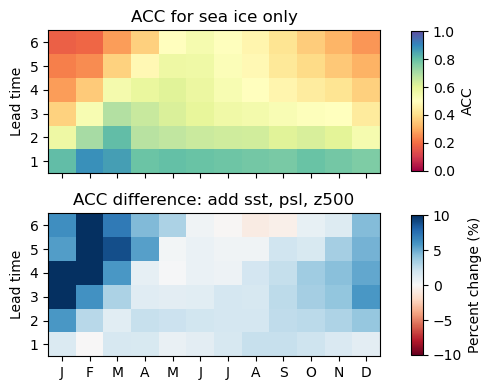

In [4]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,4), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc_agg["input2"].mean("nn_member_id")
acc_input4 = acc_agg["input4"].mean("nn_member_id")

cax = axs[0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"ACC for sea ice only")

cax2 = axs[1].pcolormesh(x, y, 100 * (acc_input4 - acc_input2) / acc_input2, cmap='RdBu', shading='flat', vmin=-10, vmax=10)
axs[1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("ACC difference: add sst, psl, z500")

cbar_ax = fig.add_axes([1.04, 0.56, 0.03, 0.35])
cbar_ax2 = fig.add_axes([1.04, 0.10, 0.03, 0.35])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'Percent change (%)', orientation='vertical')
plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_inputs_percent.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_28378/1022802866.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


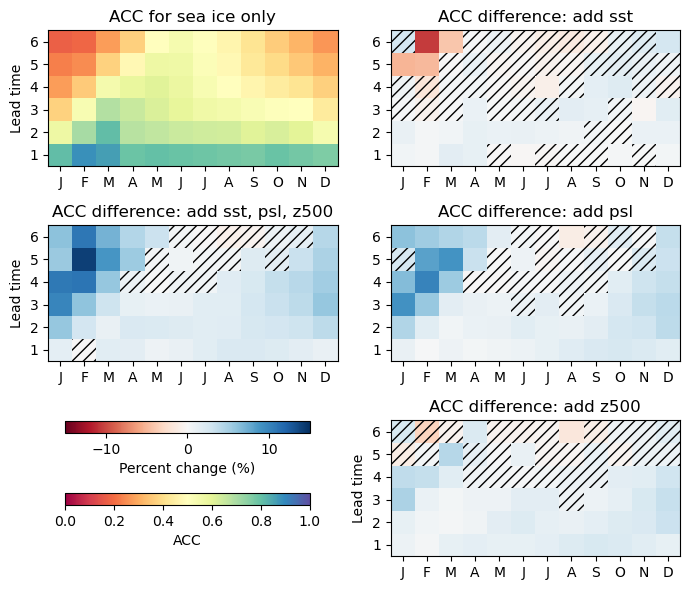

In [125]:
P_VALUE_CUTOFF = 0.05

import matplotlib.patches as mpatches

def add_hatching(ax, significance_mask, x_edges, y_edges, hatch='///', edgecolor='k'):
    Ny, Nx = significance_mask.shape

    for i in range(Ny):
        for j in range(Nx):
            if significance_mask[i, j]:
                rect = mpatches.Rectangle(
                    (x_edges[j], y_edges[i]),
                    x_edges[j+1] - x_edges[j],
                    y_edges[i+1] - y_edges[i],
                    hatch=hatch,
                    fill=False,
                    edgecolor=edgecolor,
                    linewidth=0
                )
                ax.add_patch(rect)

def plot_markers(ax, exceeds_persistence, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if not exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,6))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc_agg["input2"].mean("nn_member_id")
input_added = ["sst", "psl", "z500"]

cax2 = axs[0,0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"ACC for sea ice only")
plot_markers(axs[0,0], acc_input2 > acc_persist, x_centers, y_centers)

axs[1,0].pcolormesh(x, y, 100 * (acc_agg["input4"].mean("nn_member_id") - acc_input2) / acc_input2, 
            cmap='RdBu', shading='flat', vmin=-15, vmax=15)
significance_mask = (significance_ds["input4"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[1,0], significance_mask, x, y)

axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"ACC difference: add sst, psl, z500")

for i, input_config in enumerate(["input3a", "input3b", "input3c"]):
    cax = axs[i,1].pcolormesh(x, y, 100 * (acc_agg[input_config].mean("nn_member_id") - acc_input2) / acc_input2, 
            cmap='RdBu', shading='flat', vmin=-15, vmax=15)
    significance_mask = (significance_ds[input_config].p_value > P_VALUE_CUTOFF).astype(int)
    add_hatching(axs[i,1], significance_mask, x, y)
    axs[i,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,1].set_yticks(y_centers, labels=np.arange(1,7,1))
    axs[i,1].set_title(f"ACC difference: add {input_added[i]}")

axs[2,1].set_ylabel("Lead time")
axs[0,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[1,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2,0].remove()

cbar_ax = fig.add_axes([0.1, 0.15, 0.35, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.27, 0.35, 0.02])

plt.colorbar(cax, cax=cbar_ax2, label=r'Percent change (%)', orientation='horizontal')
plt.colorbar(cax2, cax=cbar_ax, label=r'ACC', orientation='horizontal')

plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_inputs_separate_percent.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_28378/3169216164.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


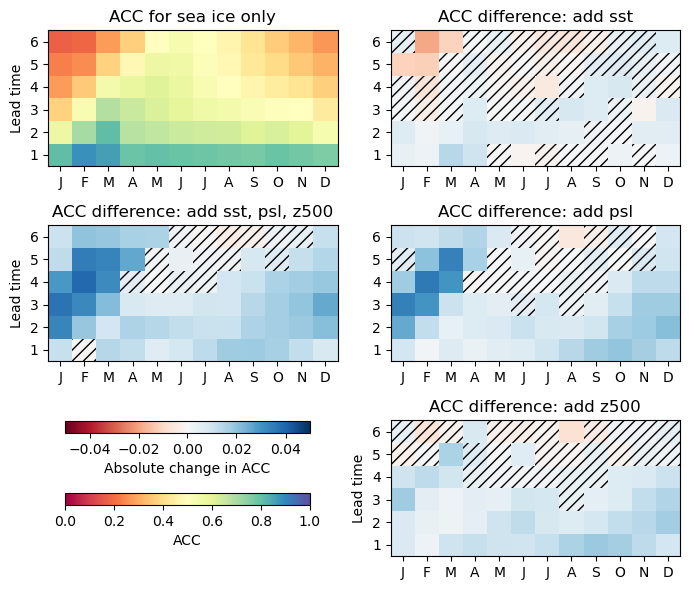

In [128]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,6))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc_agg["input2"].mean("nn_member_id")
input_added = ["sst", "psl", "z500"]

cax2 = axs[0,0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"ACC for sea ice only")
plot_markers(axs[0,0], acc_input2 > acc_persist, x_centers, y_centers)

axs[1,0].pcolormesh(x, y, acc_agg["input4"].mean("nn_member_id") - acc_input2,
            cmap='RdBu', shading='flat', vmin=-0.05, vmax=0.05)
significance_mask = (significance_ds["input4"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[1,0], significance_mask, x, y)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"ACC difference: add sst, psl, z500")

for i, input_config in enumerate(["input3a", "input3b", "input3c"]):
    cax = axs[i,1].pcolormesh(x, y, acc_agg[input_config].mean("nn_member_id") - acc_input2, 
            cmap='RdBu', shading='flat', vmin=-0.05, vmax=0.05)
    significance_mask = (significance_ds[input_config].p_value > P_VALUE_CUTOFF).astype(int)
    add_hatching(axs[i,1], significance_mask, x, y)
    axs[i,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,1].set_yticks(y_centers, labels=np.arange(1,7,1))
    axs[i,1].set_title(f"ACC difference: add {input_added[i]}")

axs[2,1].set_ylabel("Lead time")
axs[0,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[1,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2,0].remove()

cbar_ax = fig.add_axes([0.1, 0.15, 0.35, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.27, 0.35, 0.02])

plt.colorbar(cax, cax=cbar_ax2, label=r'Absolute change in ACC', orientation='horizontal')
plt.colorbar(cax2, cax=cbar_ax, label=r'ACC', orientation='horizontal')

plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_inputs_separate_abs.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_28378/2647569042.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


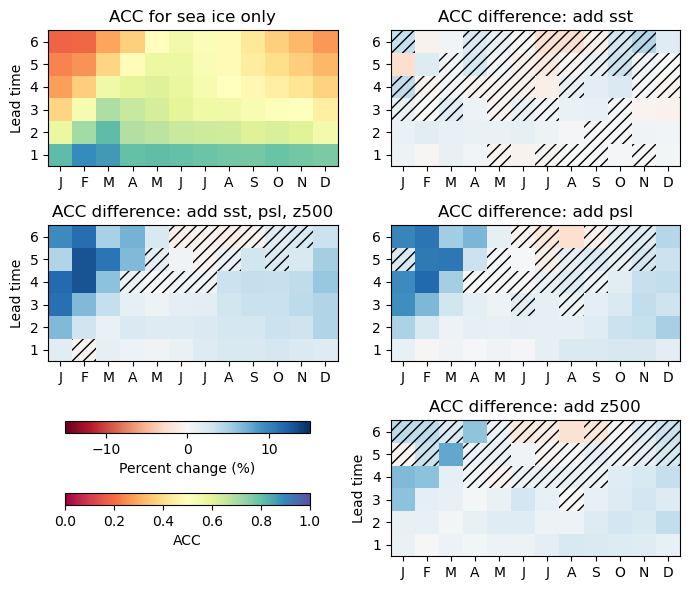

In [129]:

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,6))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc_agg["input2"].max("nn_member_id")
input_added = ["sst", "psl", "z500"]

cax2 = axs[0,0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"ACC for sea ice only")

axs[1,0].pcolormesh(x, y, 100 * (acc_agg["input4"].max("nn_member_id") - acc_input2) / acc_input2, 
            cmap='RdBu', shading='flat', vmin=-15, vmax=15)
significance_mask = (significance_ds["input4"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[1,0], significance_mask, x, y)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"ACC difference: add sst, psl, z500")

for i, input_config in enumerate(["input3a", "input3b", "input3c"]):
    cax = axs[i,1].pcolormesh(x, y, 100 * (acc_agg[input_config].max("nn_member_id") - acc_input2) / acc_input2, 
            cmap='RdBu', shading='flat', vmin=-15, vmax=15)
    significance_mask = (significance_ds[input_config].p_value > P_VALUE_CUTOFF).astype(int)
    add_hatching(axs[i,1], significance_mask, x, y)
    axs[i,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,1].set_yticks(y_centers, labels=np.arange(1,7,1))
    axs[i,1].set_title(f"ACC difference: add {input_added[i]}")

axs[2,1].set_ylabel("Lead time")
axs[0,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[1,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2,0].remove()

cbar_ax = fig.add_axes([0.1, 0.15, 0.35, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.27, 0.35, 0.02])

plt.colorbar(cax, cax=cbar_ax2, label=r'Percent change (%)', orientation='horizontal')
plt.colorbar(cax2, cax=cbar_ax, label=r'ACC', orientation='horizontal')

plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_inputs_separate_percent_max.jpg", dpi=300, bbox_inches='tight')

## Effect of normalization strategy on SST configuration skill

In [2]:
from src.experiment_configs.exp1_inputs import input3a_dev
from src.experiment_configs.exp1_inputs import input3a_std

cdicts = {
    "input3a_dev": input3a_dev, 
    "input3a_std": input3a_std, 
}

cdict = load_globals(input3a_dev)
climatology_broadcast = get_broadcast_climatology(cdict, "test")
targets = load_targets(cdict, "test", add_climatology_to_anomaly=False)

acc = {}
acc_agg = {}

num_nn_ens_members = 3
for key, config in cdicts.items():
    print(f"computing ACC for {key}")
    cdict = load_globals(config) 
    pred = load_model_predictions(cdict, nn_ens_avg=False, climatology_broadcasted=None, 
                                    add_climatology_to_anomaly=False)

    acc_temp_list = []
    for i in range(num_nn_ens_members): 
        acc_temp = calculate_acc(pred.isel(nn_member_id=i), 
                            targets, dim=("x","y"), aggregate=False)
        acc_temp_list.append(acc_temp)
    acc[key] = xr.concat(acc_temp_list, dim="nn_member_id")
    acc_agg[key] = aggregate_acc(acc[key], dim=("x","y"))

computing ACC for input3a_dev
computing ACC for input3a_std


In [5]:
save_dir = os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, "exp1_inputs")

for config in acc:
    acc[config].to_netcdf(os.path.join(save_dir, f"ACC_{config}.nc"))
    acc_agg[config].to_netcdf(os.path.join(save_dir, f"ACC_agg_{config}.nc"))

In [6]:
# load saved acc 
acc = {}
acc_agg = {}

save_dir = os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, "exp1_inputs")
for key in ["input2", "input3a", "input3a_dev", "input3a_std"]:
    acc[key] = xr.open_dataset(os.path.join(save_dir, f"ACC_{key}.nc"))["__xarray_dataarray_variable__"]
    acc_agg[key] = xr.open_dataset(os.path.join(save_dir, f"ACC_agg_{key}.nc"))["__xarray_dataarray_variable__"]

In [7]:
significance_ds = {}

for k in ["input3a", "input3a_dev", "input3a_std"]: 
    print(f"Computing bootstrap significance test for {k}")

    significance_ds[k] = bootstrap_acc_significance(acc["input2"], acc[k])

for k, ds in significance_ds.items():
    significance_ds[k] = roll_acc(ds)

Computing bootstrap significance test for input3a
Computing bootstrap significance test for input3a_dev
Computing bootstrap significance test for input3a_std


/tmp/ipykernel_20494/77099071.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


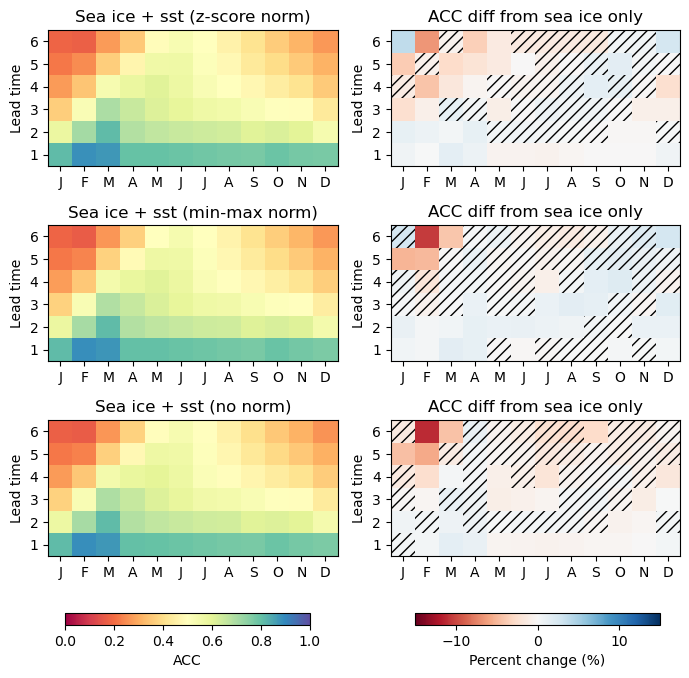

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,6))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_zscore_norm = acc_agg["input3a_std"].mean("nn_member_id")
acc_minmax_norm = acc_agg["input3a"].mean("nn_member_id")
acc_nonorm = acc_agg["input3a_dev"].mean("nn_member_id")
acc_sic_only = acc_agg["input2"].mean("nn_member_id")

cax = axs[0,0].pcolormesh(x, y, acc_zscore_norm, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"Sea ice + sst (z-score norm)")

axs[1,0].pcolormesh(x, y, acc_minmax_norm, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"Sea ice + sst (min-max norm)")

axs[2,0].pcolormesh(x, y, acc_nonorm, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[2,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2,0].set_ylabel("Lead time")
axs[2,0].set_title(f"Sea ice + sst (no norm)")

cax2 = axs[0,1].pcolormesh(x, y, 100 * (acc_zscore_norm - acc_sic_only) / acc_sic_only,
                    cmap='RdBu', shading='flat', vmin=-15, vmax=15)
axs[0,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,1].set_ylabel("Lead time")
axs[0,1].set_title(f"ACC diff from sea ice only")
significance_mask = (significance_ds["input3a_std"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[0,1], significance_mask, x, y)

axs[1,1].pcolormesh(x, y, 100 * (acc_minmax_norm - acc_sic_only) / acc_sic_only,
                    cmap='RdBu', shading='flat', vmin=-15, vmax=15)
axs[1,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,1].set_ylabel("Lead time")
axs[1,1].set_title(f"ACC diff from sea ice only")
significance_mask = (significance_ds["input3a"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[1,1], significance_mask, x, y)

axs[2,1].pcolormesh(x, y, 100 * (acc_nonorm - acc_sic_only) / acc_sic_only,
                    cmap='RdBu', shading='flat', vmin=-15, vmax=15)
axs[2,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2,1].set_ylabel("Lead time")
axs[2,1].set_title(f"ACC diff from sea ice only")
significance_mask = (significance_ds["input3a_dev"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[2,1], significance_mask, x, y)

for i in range(3):
    for j in range(2):
        axs[i,j].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.1, -0.05, 0.35, 0.02])
cbar_ax2 = fig.add_axes([0.6, -0.05, 0.35, 0.02])

plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='horizontal')
plt.colorbar(cax2, cax=cbar_ax2, label=r'Percent change (%)', orientation='horizontal')

plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_sst_norm.jpg", dpi=300, bbox_inches='tight')

## noise experiment

In [5]:
from src.experiment_configs.exp1_inputs import input_noise

cdict = load_globals(input_noise)
climatology_broadcast = get_broadcast_climatology(cdict, "test")
targets = load_targets(cdict, "test", add_climatology_to_anomaly=False)

num_nn_ens_members = 5
pred = load_model_predictions(cdict, nn_ens_avg=False, climatology_broadcasted=None, 
                                add_climatology_to_anomaly=False)

acc_temp_list = []
for i in range(num_nn_ens_members): 
    acc_temp = calculate_acc(pred.isel(nn_member_id=i), 
                        targets, dim=("x","y"), aggregate=False)
    acc_temp_list.append(acc_temp)
acc_noise = xr.concat(acc_temp_list, dim="nn_member_id")
acc_agg_noise = aggregate_acc(acc_noise, dim=("x","y"))

save_dir = os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, "exp1_inputs")
acc_noise.to_netcdf(os.path.join(save_dir, f"ACC_input_noise.nc"))
acc_agg_noise.to_netcdf(os.path.join(save_dir, f"ACC_agg_input_noise.nc"))

In [6]:
# load saved acc 
acc = {}
acc_agg = {}

save_dir = os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, "exp1_inputs")
for key in ["input2", "input_noise"]:
    acc[key] = xr.open_dataset(os.path.join(save_dir, f"ACC_{key}.nc"))["__xarray_dataarray_variable__"]
    acc_agg[key] = xr.open_dataset(os.path.join(save_dir, f"ACC_agg_{key}.nc"))["__xarray_dataarray_variable__"]

In [14]:
significance_ds = {}

for k in ["input_noise",]: 
    print(f"Computing bootstrap significance test for {k}")

    significance_ds[k] = bootstrap_acc_significance(acc["input2"], acc[k])

for k, ds in significance_ds.items():
    significance_ds[k] = roll_acc(ds)

Computing bootstrap significance test for input_noise


/tmp/ipykernel_8991/3153960016.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


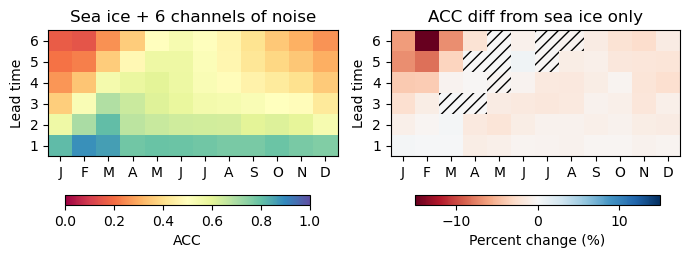

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_noise = acc_agg["input_noise"].mean("nn_member_id")
acc_sic_only = acc_agg["input2"].mean("nn_member_id")

cax = axs[0].pcolormesh(x, y, acc_noise, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"Sea ice + 6 channels of noise")

cax2 = axs[1].pcolormesh(x, y, 100 * (acc_noise - acc_sic_only) / acc_sic_only,
                    cmap='RdBu', shading='flat', vmin=-15, vmax=15)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title(f"ACC diff from sea ice only")
significance_mask = (significance_ds["input_noise"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(axs[1], significance_mask, x, y)

for i in range(2):
    axs[i].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.1, -0.05, 0.35, 0.05])
cbar_ax2 = fig.add_axes([0.6, -0.05, 0.35, 0.05])

plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='horizontal')
plt.colorbar(cax2, cax=cbar_ax2, label=r'Percent change (%)', orientation='horizontal')

plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_noise.jpg", dpi=300, bbox_inches='tight')

## Temporal dependence of ACC

### composite analysis
Here we select instances where ACC of input4 exceeds the ACC of input2 by at least `diff_thresh=0.3`. The visualizations are for initialization in October, so that we capture the  

In [5]:
test_members = ['r2i1251p1f1', 'r2i1281p1f1', 'r2i1301p1f1', 'r3i1041p1f1']
data_dir = '/scratch/users/yucli/cesm_data_processed/data_pairs/seaice_plus_temp_plus_atm_minmax'

inputs_da = []
for member_id in test_members: 
    inputs_da.append(xr.open_dataset(os.path.join(data_dir, f"inputs_member_{member_id}.nc")))

inputs_da = xr.concat(inputs_da, dim="member_id")

In [6]:
acc_diff_all = acc["input4"].mean("nn_member_id") - acc["input2"].mean("nn_member_id")

diff_thresh = 0.3
acc_diff = acc_diff_all.where(acc_diff_all > diff_thresh, drop=True)
mask = acc_diff.notnull().any(dim="lead_time")

In [46]:
inputs_subset = inputs_da.where(mask, drop=True).data

In [88]:
targets_da = []
for member_id in test_members: 
    targets_da.append(xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")))

targets_da = xr.concat(targets_da, dim="member_id")
targets_subset = targets_da.where(mask, drop=True).data

month_init_targets = targets_subset.where(targets_subset.start_prediction_month.dt.month == 10, drop=True).mean(("member_id", "start_prediction_month"))

36


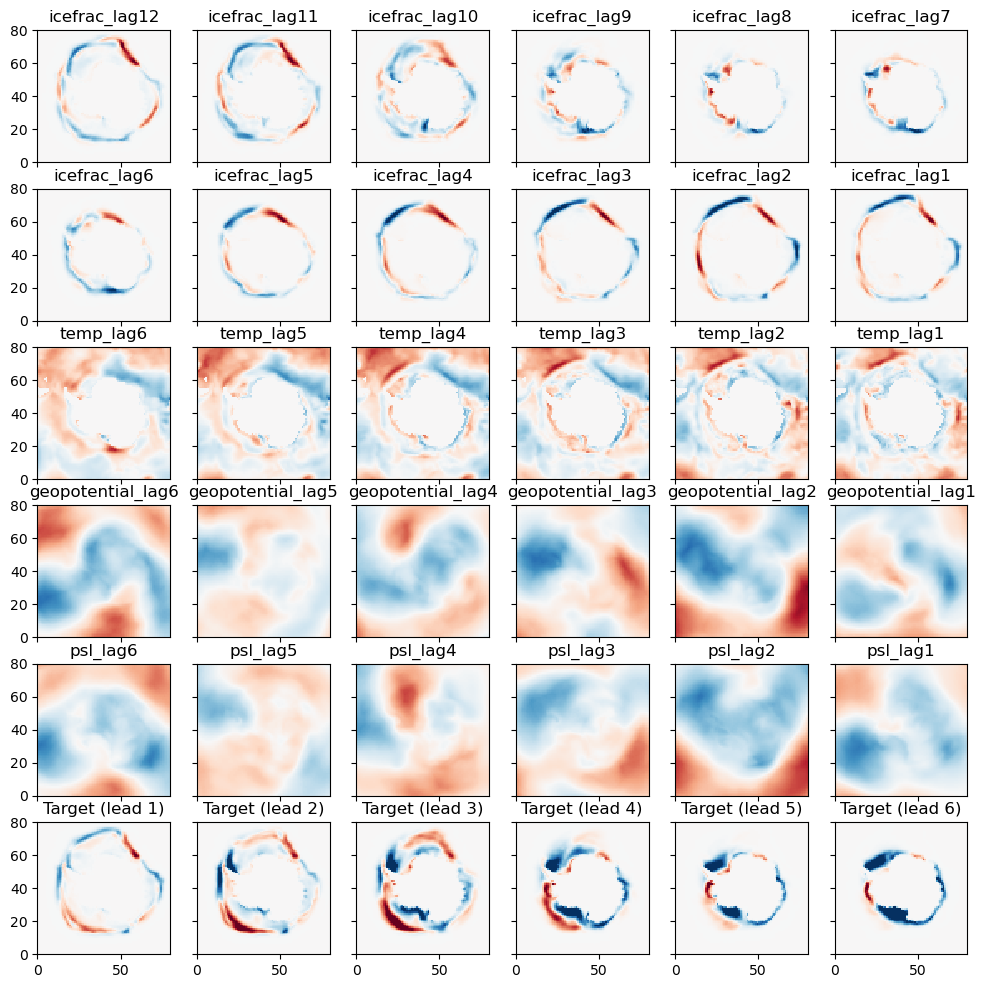

In [91]:
month_init_inputs = inputs_subset.where(inputs_subset.start_prediction_month.dt.month == 10, drop=True)
print(month_init_inputs[:,:,0,0,0].notnull().sum().values)
month_init_inputs = month_init_inputs.mean(("member_id", "start_prediction_month"))

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(12,12), sharex=True, sharey=True)

axs = axs.flatten()

for i in range(30):
    axs[i].pcolormesh(month_init_inputs.isel(channel=i), vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    axs[i].set_title(month_init_inputs.channel[i].values)

for i in range(30, 36): 
    lead = i - 30
    axs[i].pcolormesh(month_init_targets.isel(lead_time=lead), vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    axs[i].set_title(f"Target (lead {lead + 1})")

In [98]:
pred_2 = load_model_predictions(load_globals(input2), nn_ens_avg=False, climatology_broadcasted=None, 
                                add_climatology_to_anomaly=False)
pred_4 = load_model_predictions(load_globals(input4), nn_ens_avg=False, climatology_broadcasted=None, 
                                add_climatology_to_anomaly=False)

pred_2_subset = pred_2.where(mask, drop=True).mean("nn_member_id")
pred_4_subset = pred_4.where(mask, drop=True).mean("nn_member_id")

month_init_pred2 = pred_2_subset.where(pred_2_subset.start_prediction_month.dt.month == 10, drop=True).mean(("member_id", "start_prediction_month"))
month_init_pred4 = pred_4_subset.where(pred_4_subset.start_prediction_month.dt.month == 10, drop=True).mean(("member_id", "start_prediction_month"))

36


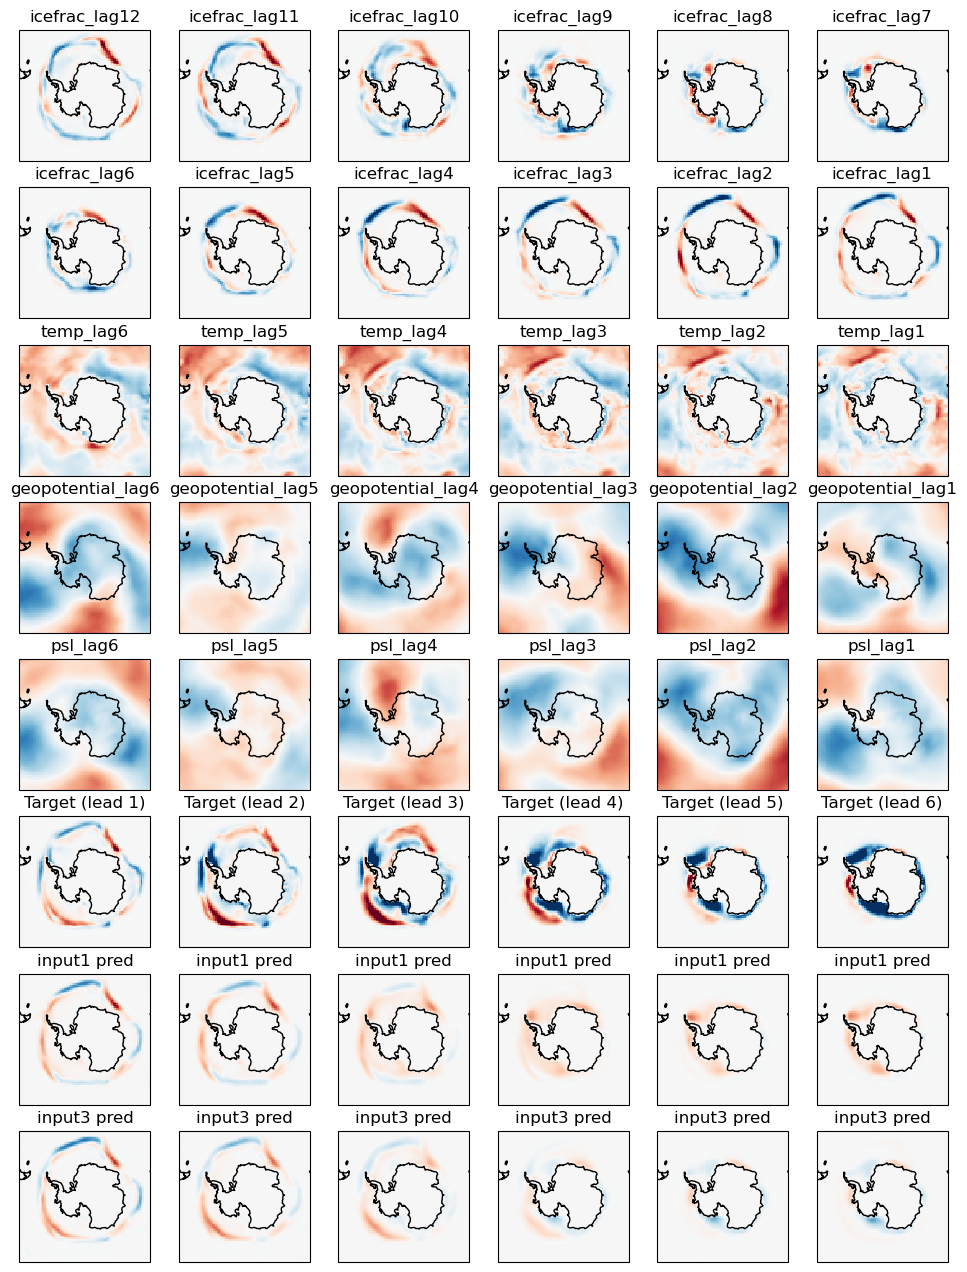

In [104]:
import cartopy.crs as ccrs

month_init_inputs = inputs_subset.where(inputs_subset.start_prediction_month.dt.month == 10, drop=True)
print(month_init_inputs[:,:,0,0,0].notnull().sum().values)
month_init_inputs = month_init_inputs.mean(("member_id", "start_prediction_month"))

lon = reference_grid.lon.data
lat = reference_grid.lat.data

fig, axs = plt.subplots(nrows=8, ncols=6, figsize=(12,16), sharex=True, sharey=True,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

axs = axs.flatten()

for i in range(30):
    axs[i].pcolormesh(lon, lat, month_init_inputs.isel(channel=i), transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    axs[i].set_title(month_init_inputs.channel[i].values)

for i in range(30, 36): 
    lead = i - 30
    axs[i].pcolormesh(lon, lat, month_init_targets.isel(lead_time=lead), transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    axs[i].set_title(f"Target (lead {lead + 1})")

for i in range(36, 42):
    axs[i].pcolormesh(lon, lat, month_init_pred2.isel(lead_time=i-36),transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    axs[i].set_title(f"input1 pred")

for i in range(42, 48):
    axs[i].pcolormesh(lon, lat, month_init_pred4.isel(lead_time=i-42), transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    axs[i].set_title(f"input3 pred")

for i in range(0, 48):
    axs[i].coastlines()

plt.savefig("figures/cesm/exp1_inputs_composite.jpg", dpi=300, bbox_inches='tight')

In [7]:
from sklearn.decomposition import PCA

In [8]:
input_vars = ["psl_lag1", "icefrac_lag1", "geopotential_lag1", "temp_lag1"]

eofs_dict = {}
pcs_dict = {}
var_exp_dict = {}
n_components = 4

for input_var in input_vars:
    stacked = inputs_da["data"].sel(channel=input_var).stack(samples=("member_id", "start_prediction_month"))
    nx, ny, nsamples = stacked.shape

    anom_matrix = (stacked - stacked.mean(("x","y"))).values.reshape(nx * ny, nsamples).T

    pca = PCA(n_components=n_components)
    pca.fit(anom_matrix)
    pcs = pca.transform(anom_matrix)
    eofs_flat = pca.components_ 
    eofs = eofs_flat.reshape(n_components, ny, nx)

    eofs_dict[input_var] = xr.DataArray(
        eofs,
        dims=("mode", "y", "x"),
        coords={"mode": np.arange(n_components), "y": stacked.y, "x": stacked.x},
        name="EOF"
    )
    
    samples_index = stacked["samples"]
    pcs_dict[input_var] = xr.DataArray(
        pcs,
        dims=("samples", "mode"),
        coords={"samples": samples_index, "mode": np.arange(n_components)},
        name="PC"
    ).unstack("samples")

    var_exp_dict[input_var] = xr.DataArray(
        pca.explained_variance_ratio_,
        dims=("mode",),
        coords={"mode": np.arange(n_components)},
        name="VarianceExplained"
    )



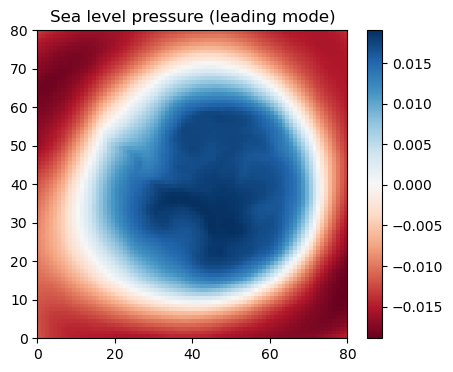

In [381]:
plt.figure(figsize=(5,4))
plt.pcolormesh(eofs_dict["psl_lag1"].isel(mode=0), cmap="RdBu")
plt.title("Sea level pressure (leading mode)")
plt.colorbar()
plt.savefig("figures/illustrations/sam.jpg",dpi=300,bbox_inches='tight')

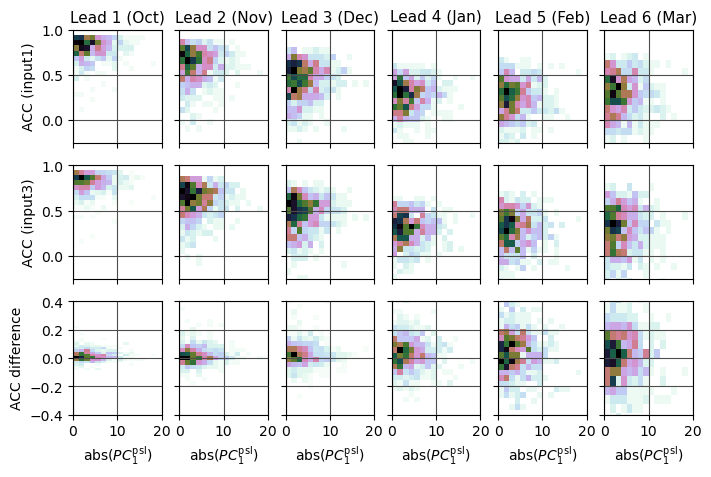

In [35]:
time = pcs_dict["icefrac_lag1"].start_prediction_month
month = 10

fig, axs = plt.subplots(figsize=(8,5), nrows=3, ncols=6, sharex=True)

cmap = plt.get_cmap("plasma").copy()

psl_pc = np.abs(pcs_dict["psl_lag1"].isel(mode=0).where(time.dt.month == month, drop=True).values.flatten())
acc_input2 = acc["input2"].mean("nn_member_id").where(time.dt.month == month, drop=True)
acc_input4 = acc["input4"].mean("nn_member_id").where(time.dt.month == month, drop=True)

months = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
for i in range(6):
    axs[0,i].hist2d(psl_pc, acc_input2.isel(lead_time=i).values.flatten(),
                    bins=[15,15], density=True, cmap="cubehelix_r")

    axs[1,i].hist2d(psl_pc, acc_input4.isel(lead_time=i).values.flatten(), 
                    bins=[15,15], density=True, cmap="cubehelix_r")

    axs[2,i].hist2d(psl_pc, (acc_input4 - acc_input2).isel(lead_time=i).values.flatten(), 
                    bins=[15,19], density=True, cmap="cubehelix_r")

    axs[0,i].set_ylim([-0.25, 1])
    axs[1,i].set_ylim([-0.25, 1])
    axs[2,i].set_ylim([-0.4, 0.4])

    for j in range(3):
        axs[j,i].set_xlim([0, 20])
        axs[j,i].set_xticks([0, 10, 20])
        
        if i > 0:
            axs[j,i].set_yticklabels([])
        
        axs[j,i].grid(color='0.3')
    
    axs[0,0].set_ylabel("ACC (input1)") #this uses the same nomenclature as the paper 
    axs[1,0].set_ylabel("ACC (input3)") 
    axs[2,0].set_ylabel("ACC difference") 
    axs[2,i].set_xlabel(rf"abs($PC_1^{{\mathrm{{psl}}}}$)")
    axs[0,i].set_title(f"Lead {i+1} ({months[i]})", fontsize=11)

plt.savefig("figures/cesm/exp1_SAM_ACC_joint_dist_sep_init.jpg", bbox_inches='tight', dpi=300)

In [38]:
var_exp_dict["psl_lag1"]

{'psl_lag1': <xarray.DataArray 'VarianceExplained' (mode: 4)> Size: 32B
 array([0.24611057, 0.11789281, 0.10908581, 0.10060635])
 Coordinates:
   * mode     (mode) int64 32B 0 1 2 3,
 'icefrac_lag1': <xarray.DataArray 'VarianceExplained' (mode: 4)> Size: 32B
 array([0.11596797, 0.10197717, 0.04786916, 0.0440614 ])
 Coordinates:
   * mode     (mode) int64 32B 0 1 2 3,
 'geopotential_lag1': <xarray.DataArray 'VarianceExplained' (mode: 4)> Size: 32B
 array([0.15849167, 0.13947579, 0.12356947, 0.09780964])
 Coordinates:
   * mode     (mode) int64 32B 0 1 2 3,
 'temp_lag1': <xarray.DataArray 'VarianceExplained' (mode: 4)> Size: 32B
 array([0.1601819 , 0.11045223, 0.08530587, 0.06661454])
 Coordinates:
   * mode     (mode) int64 32B 0 1 2 3}